This notebook contains results of:
<!-- 
- delta initialized with log prob over kmeans centers
- w relaxed one hot encoding
- responsibilities assigning the distribution
- alpha_factor = 2

Created to control if this new delta init (i.e. with inf lim over kmeans centers) changes something in the inference. -->

In [1]:
import model_mobster_mv_new as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats

import torch
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def log_sum_exp(args):
    if len(args.shape) == 1:
        args = args.unsqueeze(0)
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(NV, DP, a_beta, b_beta):
    return dist.BetaBinomial(a_beta, b_beta, total_count=DP).log_prob(NV) # simply does log(density)

def pareto_lk(mb, NV, DP, alpha):
    LINSPACE = 8000
    x = torch.linspace(mb.pareto_L, mb.pareto_H, LINSPACE)
    y_1 = BoundedPareto(mb.pareto_L, alpha, mb.pareto_H).log_prob(x).exp()
    y_2 = dist.Binomial(probs = x.repeat([NV.shape[0],1]).reshape([LINSPACE,-1]), total_count=DP).log_prob(NV).exp()
    paretobin = torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()
    # 1. pareto = simpson((y_1.reshape([LINSPACE, 1]) * y_2).numpy(), x=x.numpy(), axis=0)
    # 1. pareto = torch.tensor(pareto).log()
    # 2. p = BoundedPareto(0.01, alpha, 0.55).sample()
    # 2. paretobin = dist.Binomial(probs=p, total_count=DP).log_prob(data)
    return paretobin # N x D (if D = 1, only N)

def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    """
    Function to compute the likelihood of the data in a single given dimension.
    """
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        # return log_sum_exp(beta_lk(NV, DP, a_beta, b_beta)).sum()
        return beta_lk(NV, DP, a_beta, b_beta).sum()
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim] * mb.alpha_factor
        # return log_sum_exp(pareto_lk(mb, NV, DP, alpha)).sum()
        return pareto_lk(mb, NV, DP, alpha).sum()

def compute_likelihood2(mb, NV, DP, beta = True, idx_data = 0, dim = 0, k = 0):
    """
    Function to compute the likelihood of a specific indexed data in a single given dimension.
    """
    NV = NV[:, dim]
    DP = DP[:, dim]
    if beta == True:
        phi_beta = mb.params["phi_beta_param"][k, dim]
        k_beta = mb.params["k_beta_param"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        return beta_lk(NV, DP, a_beta, b_beta)[idx_data] # only take the log-likelihood for a specific datapoint
    else:
        alpha = mb.params["alpha_pareto_param"][k, dim] * mb.alpha_factor
        return pareto_lk(mb, NV, DP, alpha)[idx_data]

def sum_pareto_bin(mb, NV, DP, idx_data = 0, k = 0):
    delta = mb.params["delta_param"][k, :, :] # K x D x 2
    dim = 0
    delta_pareto_0 = delta[dim, 0] + torch.exp(compute_likelihood2(mb, NV, DP, beta = False, idx_data=idx_data, dim=dim, k=k))
    delta_beta_0 = delta[dim, 1] + torch.exp(compute_likelihood2(mb, NV, DP, beta = True, idx_data=idx_data, dim=dim, k=k))
    dim_0 = torch.log(delta_pareto_0+delta_beta_0)
    dim = 1
    delta_pareto_1 = delta[dim, 0] + torch.exp(compute_likelihood2(mb, NV, DP, beta = False, idx_data=idx_data, dim=dim, k=k))
    delta_beta_1 = delta[dim, 1] + torch.exp(compute_likelihood2(mb, NV, DP, beta = True, idx_data=idx_data, dim=dim, k=k))
    print("delta_pareto_1", delta_pareto_1)
    print("delta_beta_1", delta_beta_1)
    dim_1 = torch.log(delta_pareto_1+delta_beta_1)
    return dim_0 + dim_1


### rRACES data

In [3]:
NV_r = pd.read_csv("./rRACES_data/NV2.csv")
DP_r = pd.read_csv("./rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


In [4]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0097)
tensor(0.0092)


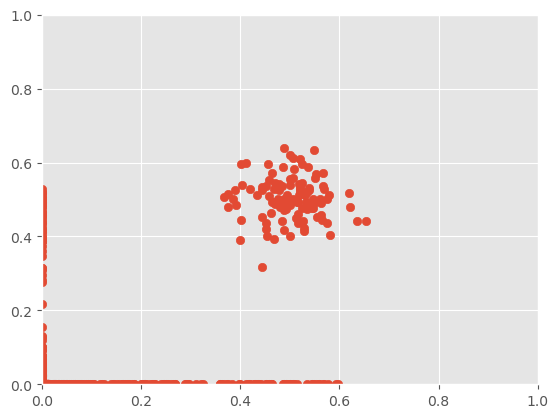

In [5]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

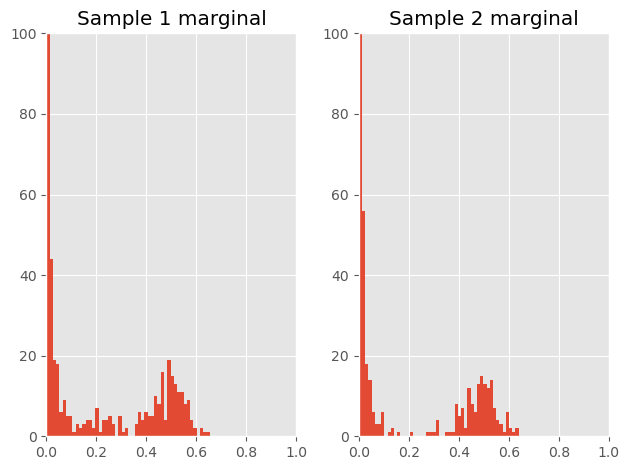

In [6]:
# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[2.1703e-01, 4.4703e-08],
        [4.9993e-01, 5.0346e-01],
        [1.0000e-03, 4.2671e-01],
        [4.6957e-01, 4.4703e-08],
        [1.4685e-02, 1.4474e-02]])
Cluster Sizes: [ 50 105  46  58 334]
Cluster Sizes Vector: [0.08431703 0.17706577 0.07757167 0.09780776 0.56323777]
Cluster variances [[331.7503658  331.7503658 ]
 [150.79538045 150.79538045]
 [218.94510456 218.94510456]
 [253.59698898 253.59698898]
 [856.990159   856.990159  ]]


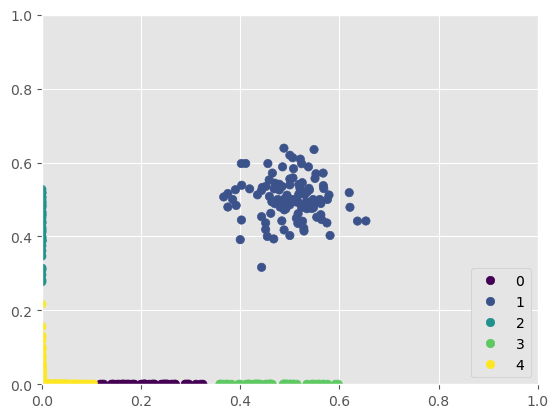

In [7]:
from sklearn.cluster import KMeans
K = 5
kmeans = KMeans(n_clusters=K, random_state=123, n_init=2).fit((NV/DP).numpy())
labels = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

plt.xlim([0,1])
plt.ylim([0,1])
sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)
legend1 = plt.legend(*sc.legend_elements(), loc="lower right")
plt.gca().add_artist(legend1)

# print(labels.astype(int))
# Compute cluster sizes
cluster_sizes = np.bincount(labels.astype(int), minlength=K)
print("Cluster Sizes:", cluster_sizes)

# Convert to a 1D vector
cluster_sizes_vector = cluster_sizes.reshape(-1)/np.sum(cluster_sizes.reshape(-1))
print("Cluster Sizes Vector:", cluster_sizes_vector)

centroids = kmeans.cluster_centers_
variances = []
for i in range(kmeans.n_clusters):
    vaf = NV/DP
    points_in_cluster = vaf[labels == i]
    
    # Get the centroid of the current cluster
    centroid = centroids[i]

    # Calculate the squared distances of points to the centroid
    distances = np.linalg.norm(points_in_cluster - centroid, axis=1) ** 2

    # Compute the variance (mean of squared distances)
    cluster_variance = np.mean(distances)
    variances.append(cluster_variance)

kappas = [1 / variance if variance > 0 else np.inf for variance in variances]
kappas = np.tile(kappas, (NV.shape[1], 1)).T
print("Cluster variances", kappas)

### Run with NV = 0 and responsibilities using integration

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(488)
NV = 0 after: tensor(488)
delta_param tensor([[[0.3968, 0.6032],
         [0.4010, 0.5990]],

        [[0.4042, 0.5958],
         [0.4044, 0.5956]],

        [[0.4041, 0.5959],
         [0.6042, 0.3958]],

        [[0.5960, 0.4040],
         [0.4042, 0.5958]],

        [[0.3960, 0.6040],
         [0.6038, 0.3962]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2357233.4708299637
Iteration 200: Loss = 1929413.2653360367
Iteration 400: Loss = 1944533.0431070328
Iteration 600: Loss = 2256364.257584572
Iteration 800: Loss = 2042560.9543008804
Iteration 1000: Loss = 1807326.4125528336
Iteration 1200: Loss = 2285226.619339943
Iteration 1400: Loss = 1856559.9501504898
Iteration 1600: Loss = 2044908.3368692398
Iteration 1800: Loss = 1887396.645951271
Iteration 2000: Loss = 1919795.3097696304
Iteration 2200: Loss = 1856123.6057901382
Iteration 2400: Loss = 2538888.6366739273
Iteration 2600: Loss = 1830258.2110147476
Iteration 2800: Loss = 1

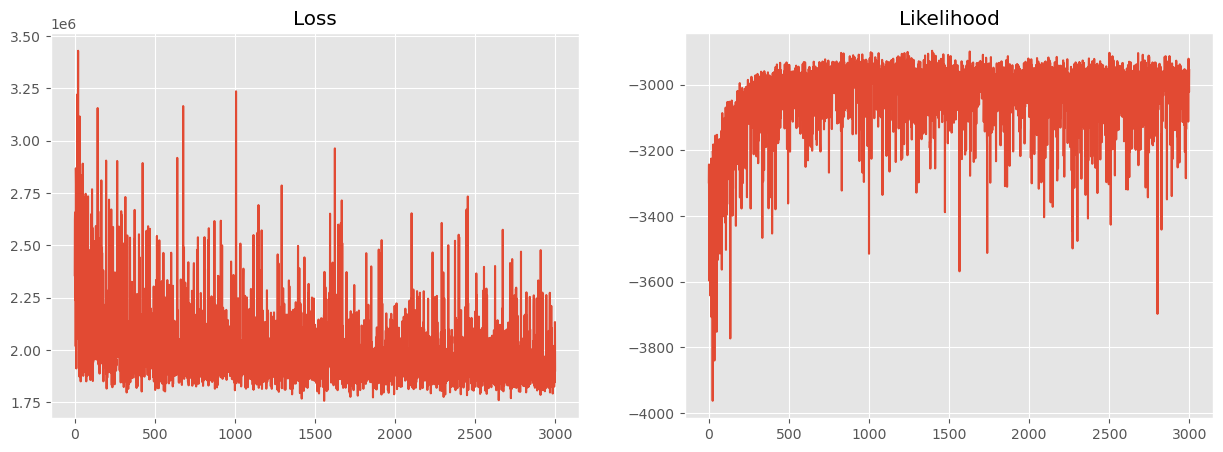

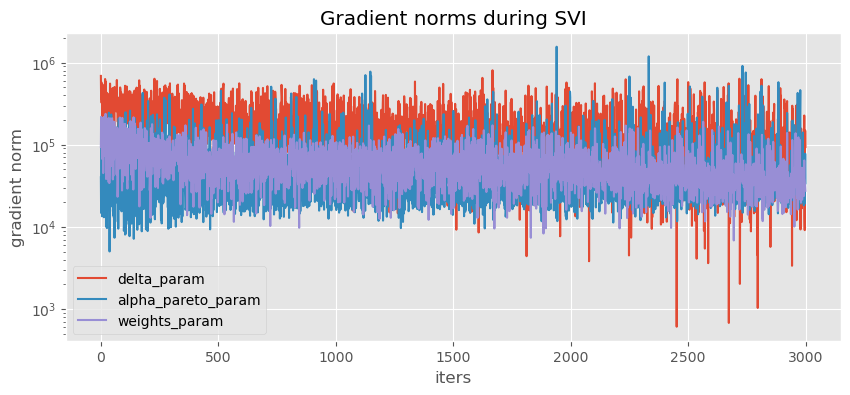

bic:  tensor(32830.7070, grad_fn=<RsubBackward1>)


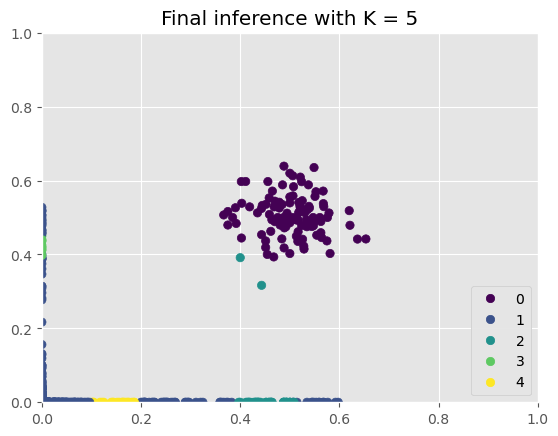

Selected number of clusters is 5 with seed 40


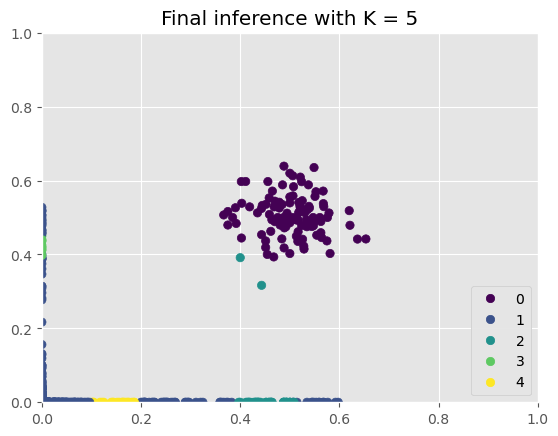

In [8]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [40], lr = 0.005)

In [48]:
alpha = final_mb.params["alpha_pareto_param"] * final_mb.alpha_factor
delta = final_mb.params["delta_param"]  # K x D x 2

phi_beta = final_mb.params["phi_beta_param"]
k_beta = final_mb.params["k_beta_param"]
a_beta = phi_beta * k_beta
b_beta = (1-phi_beta) * k_beta
weights = final_mb.params["weights_param"]
labels = final_mb.params["cluster_assignments"]
mask = (NV[:,0]/DP[:,0] > 0.4) & (labels == 1)

In [73]:
clust = 2
d = 0
betabin = torch.log(weights[clust])+dist.BetaBinomial(a_beta[clust,d], b_beta[clust,d], total_count=DP[:,d]).log_prob(NV[:,d])
print(betabin[mask])

d = 1
# NV[mask]/DP[mask]
# print(BoundedPareto(final_mb.pareto_L, alpha[1], final_mb.pareto_H).log_prob(NV[mask]/DP[mask]))
LINSPACE = 30000
x = torch.linspace(final_mb.pareto_L, final_mb.pareto_H, LINSPACE)
y_1 = BoundedPareto(final_mb.pareto_L, alpha[clust,d], final_mb.pareto_H).log_prob(x).exp()
y_2 = dist.Binomial(probs = x.repeat([final_mb.NV.shape[0], 1]).reshape([LINSPACE,-1]), total_count=final_mb.DP[:,d]).log_prob(final_mb.NV[:,d]).exp()
paretobin = torch.log(weights[clust])+torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()
print(paretobin[mask])

tensor([-6.9315, -6.4166, -4.7713, -4.7104, -4.6389, -5.2384, -4.7200, -5.3166,
        -7.5439, -4.9619, -4.8647, -5.9362, -4.7319, -5.0647, -4.7552, -5.6950,
        -5.0023, -6.2089, -4.9619, -4.6264, -4.6741, -4.6526, -5.2806, -5.1059,
        -5.0510, -4.5910, -5.0860, -4.9515, -4.7319, -4.9511, -5.0270, -4.8038,
        -4.9523], grad_fn=<IndexBackward0>)
tensor([-6.0929, -5.8083, -6.0387, -6.2044, -5.9657, -6.1452, -5.9353, -6.4423,
        -6.1922, -6.1249, -5.9465, -6.2945, -6.1930, -6.0601, -6.0469, -6.5958,
        -6.2709, -5.8783, -5.9664, -6.6496, -6.1163, -5.9241, -6.1988, -6.1242,
        -6.1587, -5.9744, -5.9195, -5.8007, -6.3000, -5.9011, -5.9230, -6.1193,
        -6.1624], grad_fn=<IndexBackward0>)


In [74]:
d = 0
clust = 1
x = torch.linspace(final_mb.pareto_L, final_mb.pareto_H, LINSPACE)
y_1 = BoundedPareto(final_mb.pareto_L, alpha[clust,d], final_mb.pareto_H).log_prob(x).exp()
y_2 = dist.Binomial(probs = x.repeat([final_mb.NV.shape[0], 1]).reshape([LINSPACE,-1]), total_count=final_mb.DP[:,d]).log_prob(final_mb.NV[:,d]).exp()
paretobin0 = torch.log(weights[clust])+torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()
print(paretobin0[mask])

d = 1
y_1 = BoundedPareto(final_mb.pareto_L, alpha[clust,d], final_mb.pareto_H).log_prob(x).exp()
y_2 = dist.Binomial(probs = x.repeat([final_mb.NV.shape[0], 1]).reshape([LINSPACE,-1]), total_count=final_mb.DP[:,d]).log_prob(final_mb.NV[:,d]).exp()
paretobin1 = torch.log(weights[clust])+torch.trapz(y_1.reshape([LINSPACE, 1]) * y_2, x =  x, dim = 0).log()
print(paretobin1[mask])

tensor([-6.2085, -5.8702, -5.0840, -4.9184, -4.8831, -5.2204, -4.9441, -5.1658,
        -6.6204, -5.0419, -5.1691, -5.5652, -4.9667, -5.1337, -5.0122, -5.3989,
        -5.1113, -5.7862, -5.0580, -4.8244, -4.8849, -4.9071, -5.2333, -5.0770,
        -5.1695, -4.8185, -5.1305, -5.0767, -4.9701, -4.9676, -5.1450, -5.0456,
        -5.0073], grad_fn=<IndexBackward0>)
tensor([-4.9779, -4.6942, -4.9239, -5.0845, -4.8472, -5.0257, -4.8171, -5.3211,
        -5.0725, -5.0048, -4.7964, -5.1734, -5.0726, -4.9380, -4.9249, -5.4691,
        -5.1472, -4.7600, -4.8476, -5.4878, -4.9969, -4.8056, -5.0438, -4.9706,
        -5.0069, -4.8554, -4.8007, -4.6824, -5.1777, -4.7812, -4.8030, -4.9934,
        -5.0361], grad_fn=<IndexBackward0>)


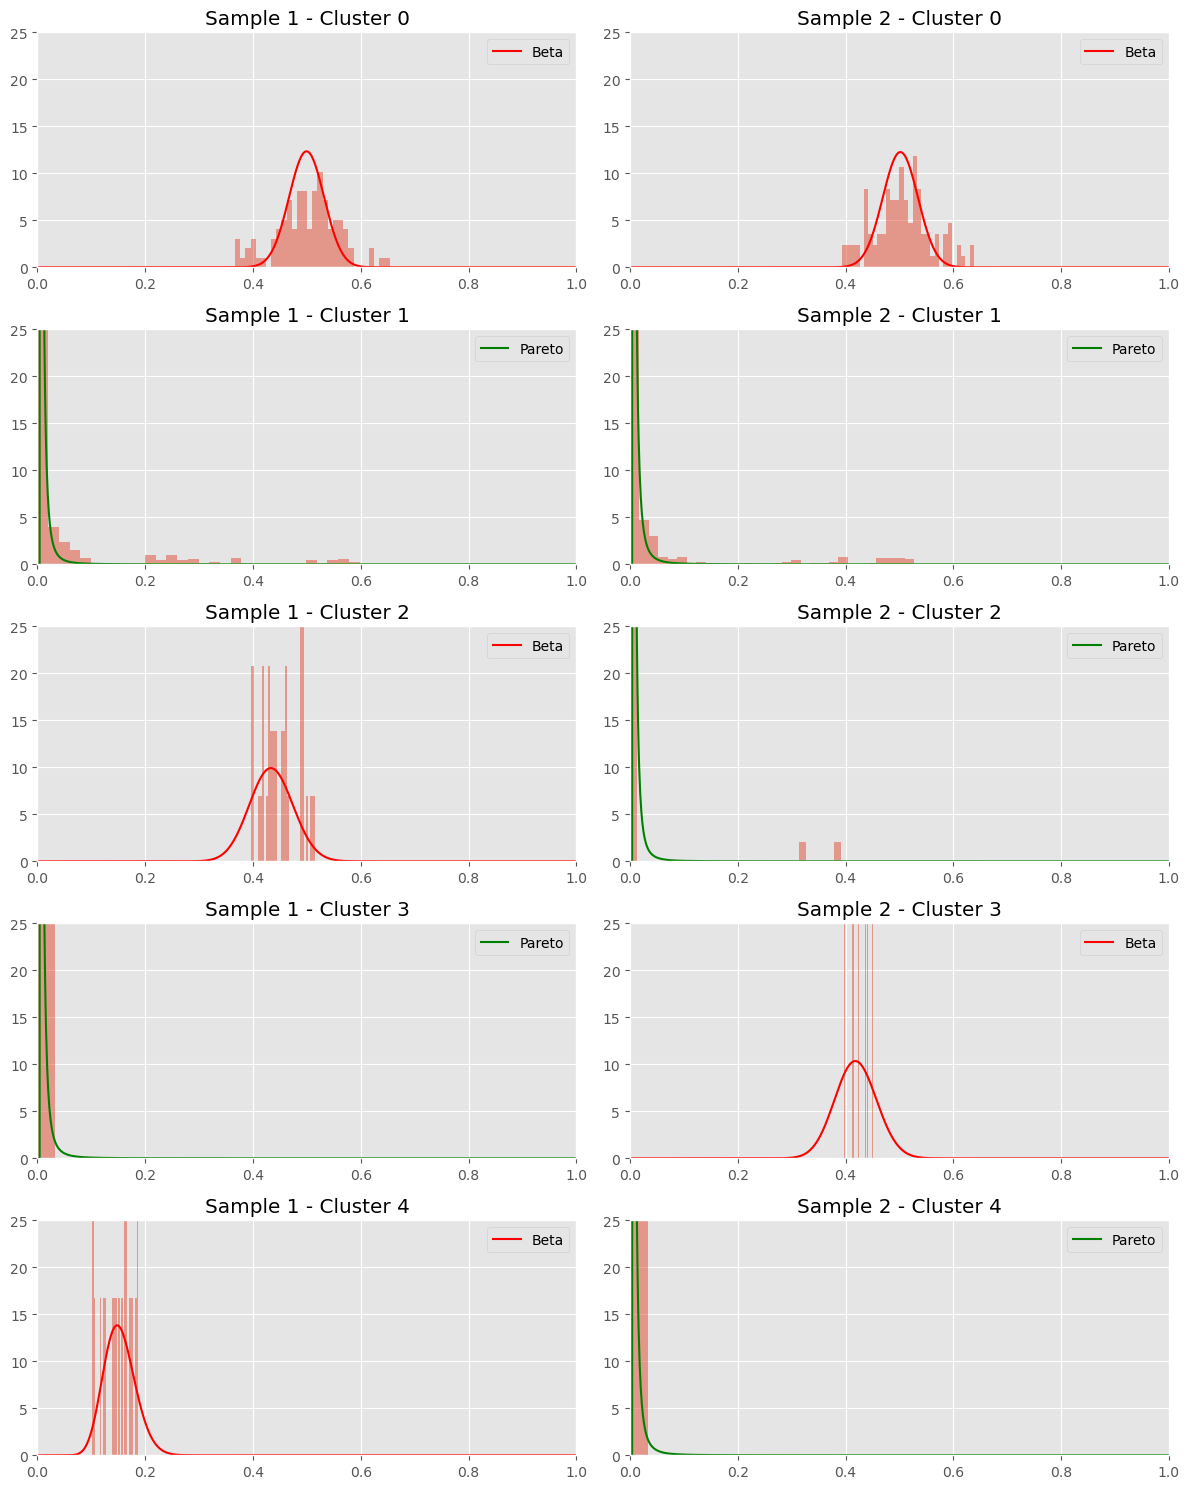

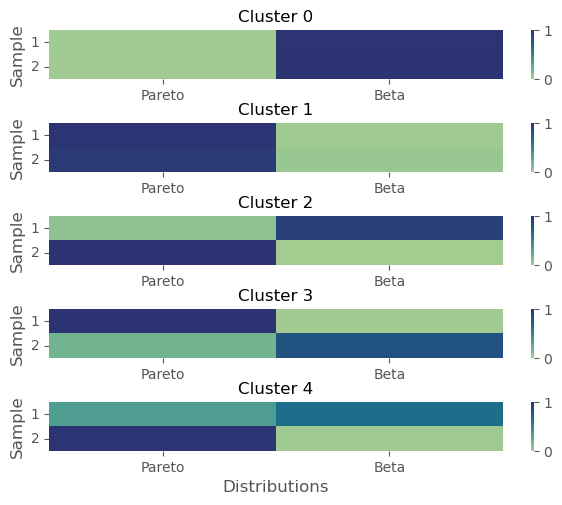

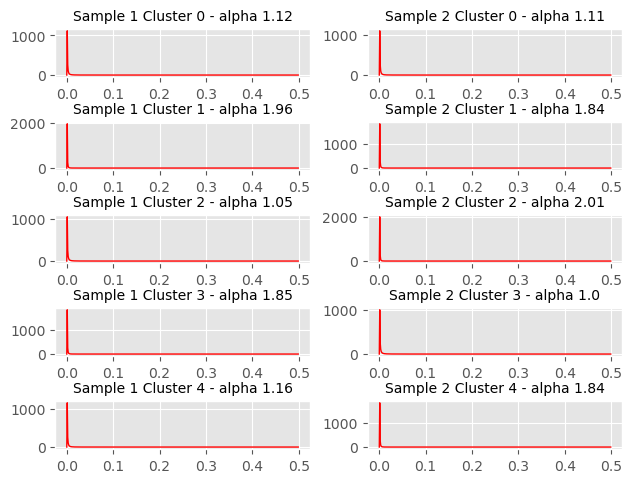

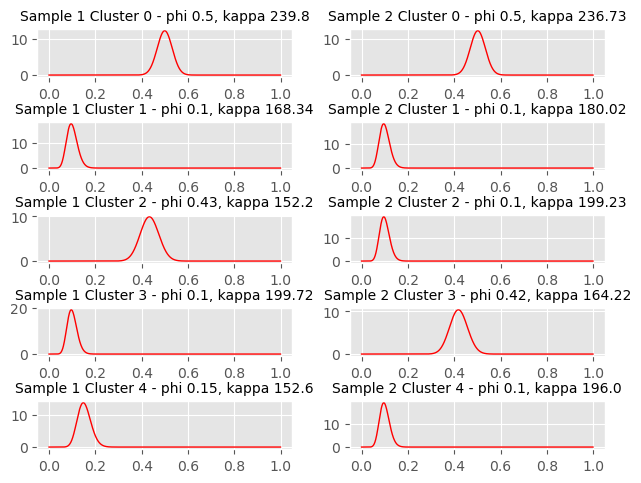

In [59]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [60]:
final_mb.params

{'weights_param': tensor([0.1820, 0.4048, 0.1303, 0.1115, 0.1715], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.1184, 1.1111],
         [1.9647, 1.8394],
         [1.0515, 2.0071],
         [1.8469, 0.9953],
         [1.1611, 1.8441]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4993, 0.5017],
         [0.1000, 0.1000],
         [0.4339, 0.1000],
         [0.1000, 0.4190],
         [0.1524, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[239.8008, 236.7251],
         [168.3396, 180.0233],
         [152.2041, 199.2348],
         [199.7223, 164.2205],
         [152.6040, 196.0022]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0181, 0.9819],
          [0.0143, 0.9857]],
 
         [[0.9753, 0.0247],
          [0.9532, 0.0468]],
 
         [[0.0846, 0.9154],
          [0.9894, 0.0106]],
 
         [[0.9860, 0.0140],
          [0.1829, 0.8171]],
 
         [[0.3411, 0.6589],
          [0.9739, 0.0261]]], grad_fn=<Di

### Run with NV = 0 and responsibilities using pareto sampling

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(488)
NV = 0 after: tensor(488)
delta_param tensor([[[0.3968, 0.6032],
         [0.4010, 0.5990]],

        [[0.4042, 0.5958],
         [0.4044, 0.5956]],

        [[0.4041, 0.5959],
         [0.6042, 0.3958]],

        [[0.5960, 0.4040],
         [0.4042, 0.5958]],

        [[0.3960, 0.6040],
         [0.6038, 0.3962]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2357233.4708299637
Iteration 200: Loss = 1929413.2653360367
Iteration 400: Loss = 1944533.0431070328
Iteration 600: Loss = 2256364.257584572
Iteration 800: Loss = 2042560.9543008804
Iteration 1000: Loss = 1807326.4125528336
Iteration 1200: Loss = 2285226.619339943
Iteration 1400: Loss = 1856559.9501504898
Iteration 1600: Loss = 2044908.3368692398
Iteration 1800: Loss = 1887396.645951271
Iteration 2000: Loss = 1919795.3097696304
Iteration 2200: Loss = 1856123.6057901382
Iteration 2400: Loss = 2538888.6366739273
Iteration 2600: Loss = 1830258.2110147476
Iteration 2800: Loss = 1

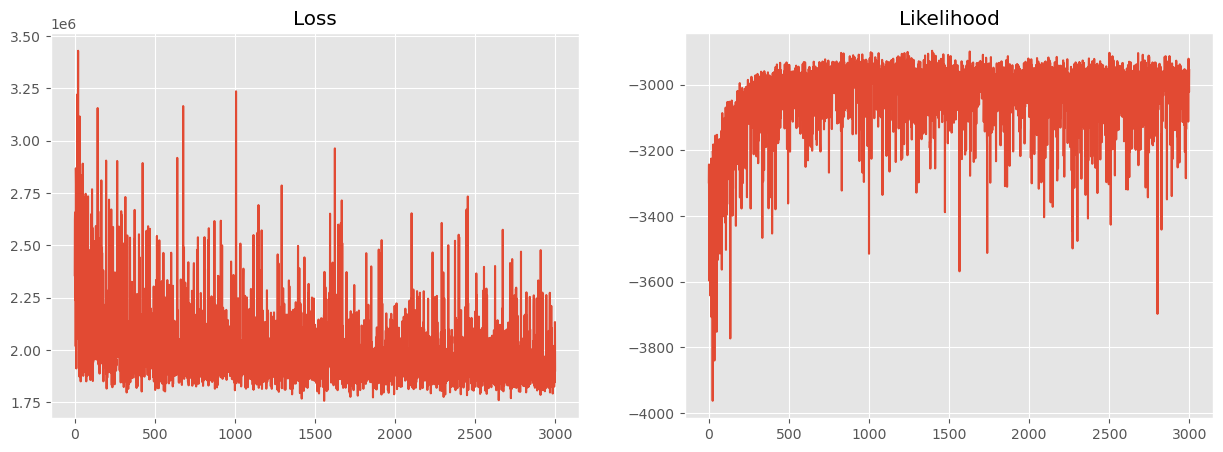

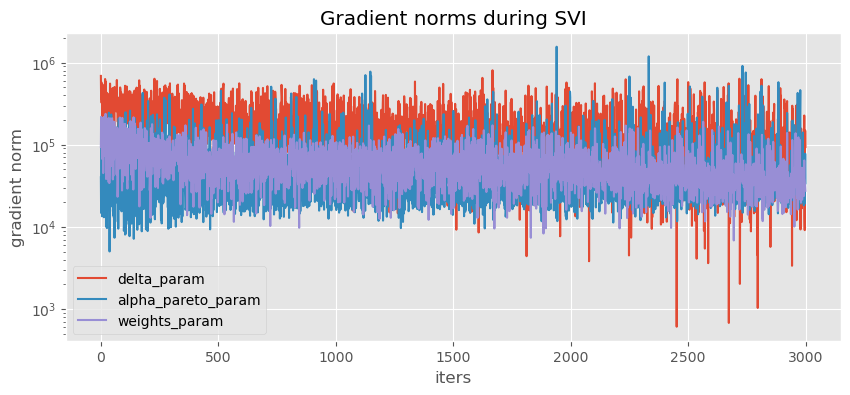

bic:  tensor(29326.5078, grad_fn=<RsubBackward1>)


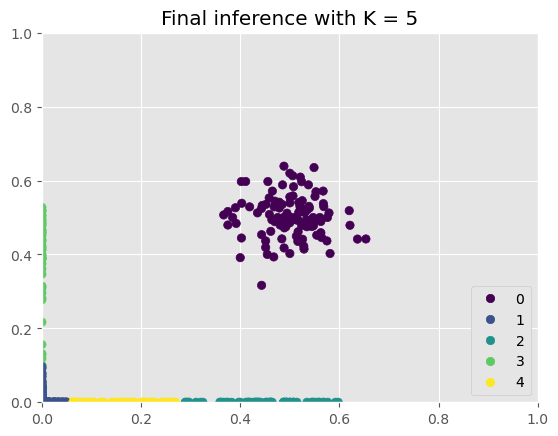

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(488)
NV = 0 after: tensor(488)
delta_param tensor([[[0.4040, 0.5960],
         [0.4009, 0.5991]],

        [[0.4042, 0.5958],
         [0.4046, 0.5954]],

        [[0.4040, 0.5960],
         [0.6047, 0.3953]],

        [[0.6042, 0.3958],
         [0.4043, 0.5957]],

        [[0.4039, 0.5961],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2639672.4755601883
Iteration 200: Loss = 2793159.7460184097
Iteration 400: Loss = 2426012.4964151382
Iteration 600: Loss = 1853656.2710733414
Iteration 800: Loss = 1894737.2400064468
Iteration 1000: Loss = 2325575.3870401382
Iteration 1200: Loss = 2204922.104447365
Iteration 1400: Loss = 2127158.4999551773
Iteration 1600: Loss = 1980413.6870889664
Iteration 1800: Loss = 1985976.9948282242
Iteration 2000: Loss = 1867838.612748146
Iteration 2200: Loss = 1975862.4616250992
Iteration 2400: Loss = 1991645.4816446304
Iteration 2600: Loss = 1957418.406449318
Iteration 2800: Loss = 1

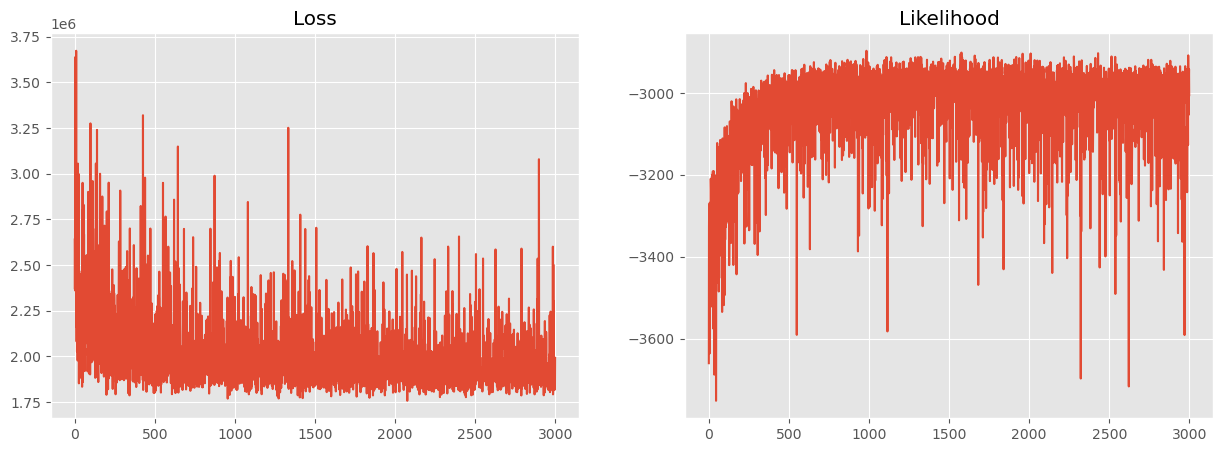

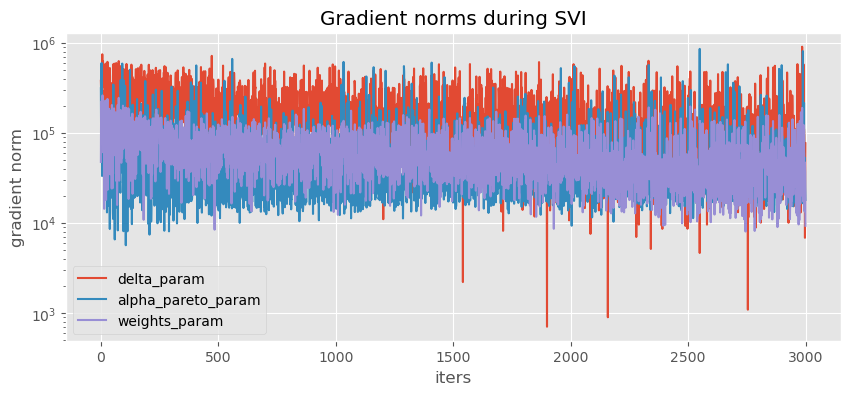

bic:  tensor(29353.9238, grad_fn=<RsubBackward1>)


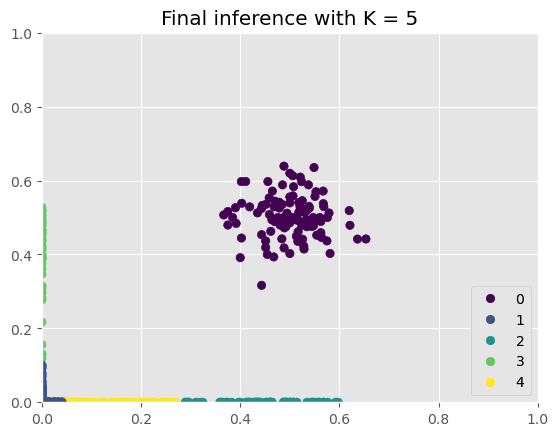

Selected number of clusters is 5 with seed 40


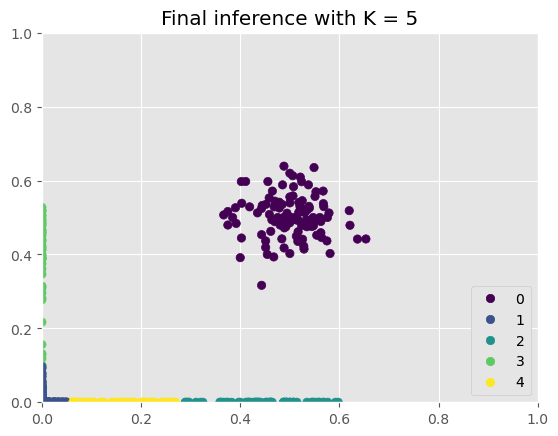

In [8]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [40,41], lr = 0.005)

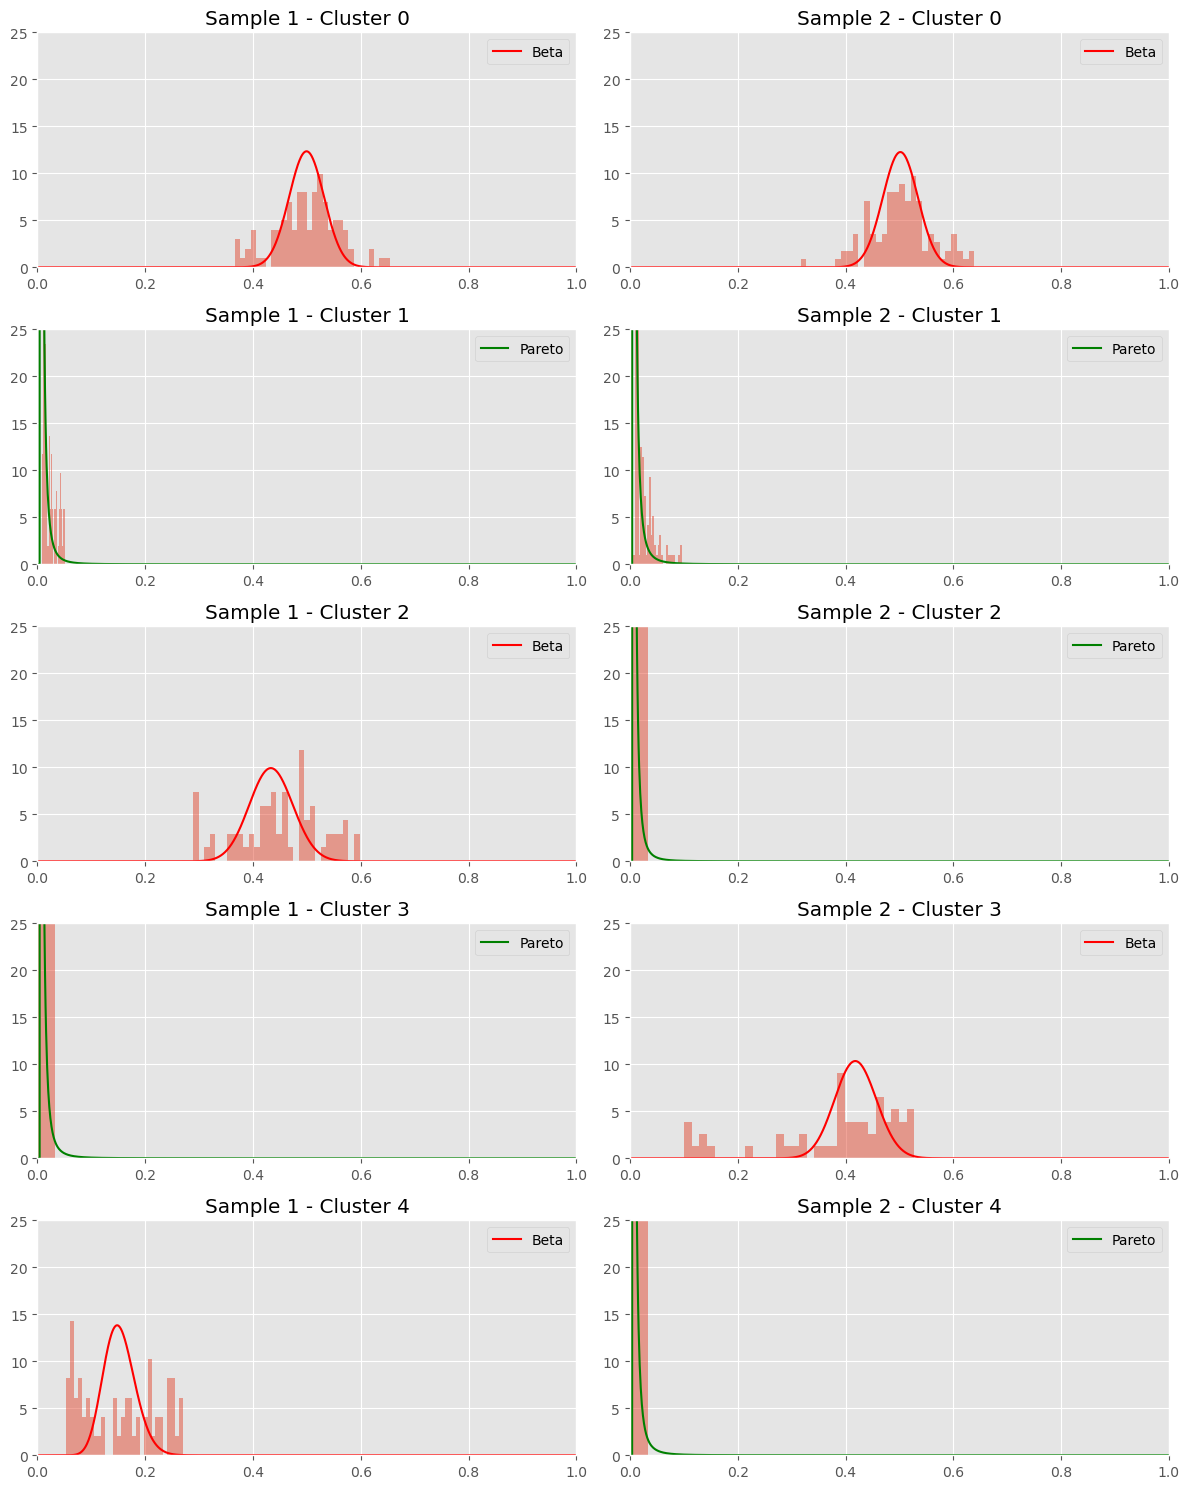

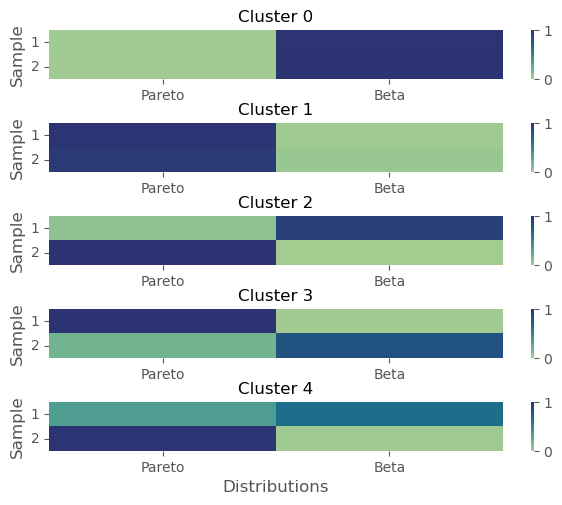

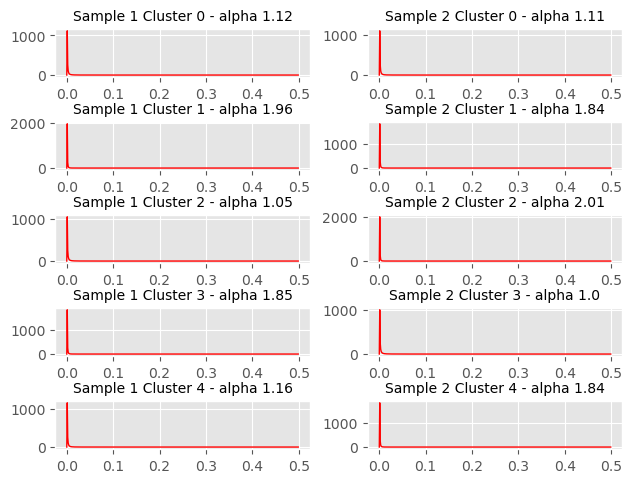

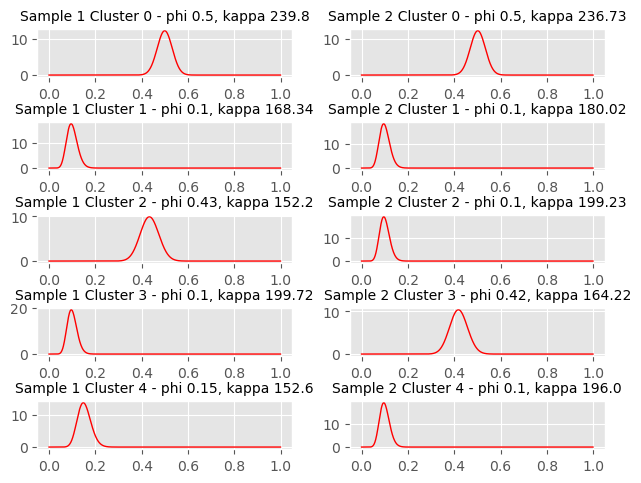

In [13]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [12]:
final_mb.params

{'weights_param': tensor([0.1820, 0.4048, 0.1303, 0.1115, 0.1715], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.1184, 1.1111],
         [1.9647, 1.8394],
         [1.0515, 2.0071],
         [1.8469, 0.9953],
         [1.1611, 1.8441]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4993, 0.5017],
         [0.1000, 0.1000],
         [0.4339, 0.1000],
         [0.1000, 0.4190],
         [0.1524, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[239.8008, 236.7251],
         [168.3396, 180.0233],
         [152.2041, 199.2348],
         [199.7223, 164.2205],
         [152.6040, 196.0022]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0181, 0.9819],
          [0.0143, 0.9857]],
 
         [[0.9753, 0.0247],
          [0.9532, 0.0468]],
 
         [[0.0846, 0.9154],
          [0.9894, 0.0106]],
 
         [[0.9860, 0.0140],
          [0.1829, 0.8171]],
 
         [[0.3411, 0.6589],
          [0.9739, 0.0261]]], grad_fn=<Di

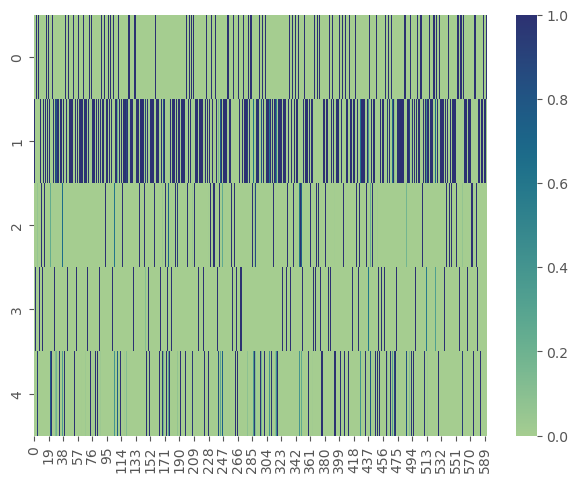

In [11]:
plot_responsib(final_mb)

### Run with all NV != 0 and responsibilities using integration

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(488)
NV = 0 after: tensor(0)
delta_param tensor([[[0.3975, 0.6025],
         [0.3958, 0.6042]],

        [[0.4042, 0.5958],
         [0.4043, 0.5957]],

        [[0.4042, 0.5958],
         [0.4042, 0.5958]],

        [[0.3960, 0.6040],
         [0.4043, 0.5957]],

        [[0.3961, 0.6039],
         [0.6032, 0.3968]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2456963.9424295425
Iteration 200: Loss = 2108234.5004434586
Iteration 400: Loss = 1985106.4397745132
Iteration 600: Loss = 2076970.9997110367
Iteration 800: Loss = 1948529.9585733414
Iteration 1000: Loss = 2089569.9634561539
Iteration 1200: Loss = 2132584.8902139664
Iteration 1400: Loss = 2023507.1918497086
Iteration 1600: Loss = 2124005.3258829117
Iteration 1800: Loss = 2069320.7389688492
Iteration 2000: Loss = 2005856.2544717789
Iteration 2200: Loss = 2074421.3997354507
Iteration 2400: Loss = 1951947.5176553726
Iteration 2600: Loss = 2049518.5617227554
Iteration 2800: Loss = 

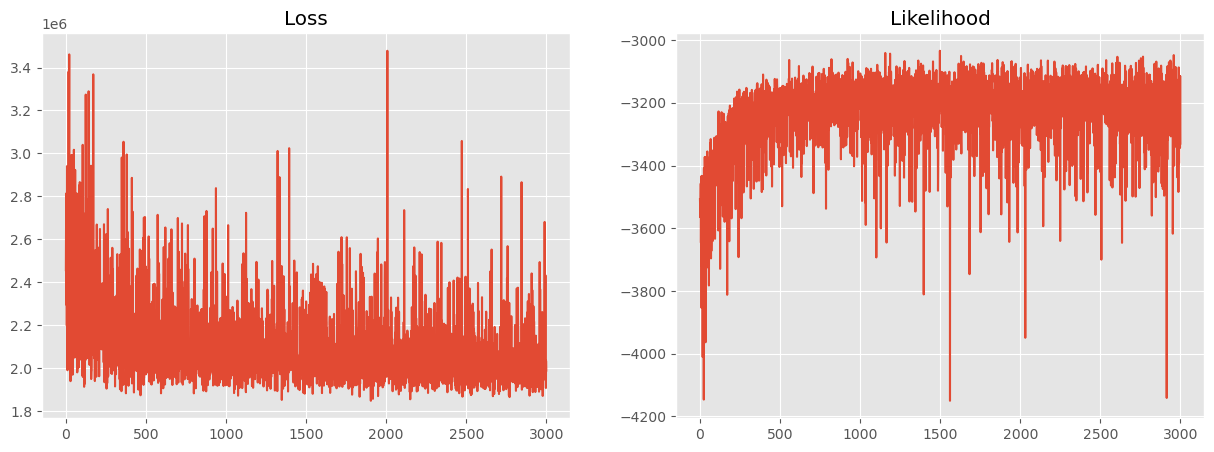

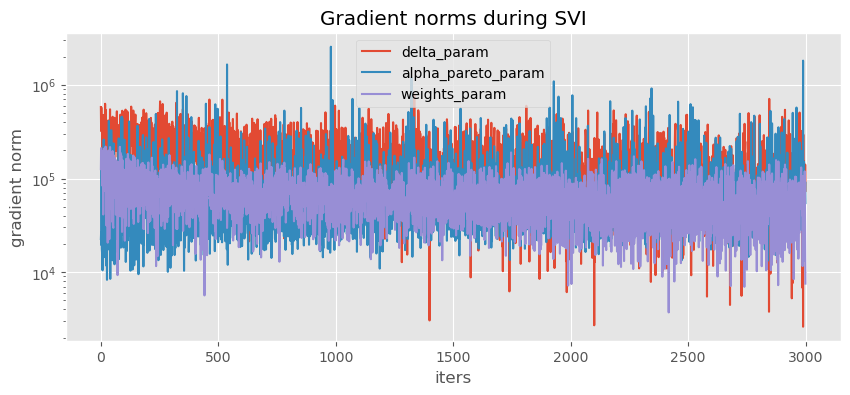

bic:  tensor(32570.9102, grad_fn=<RsubBackward1>)


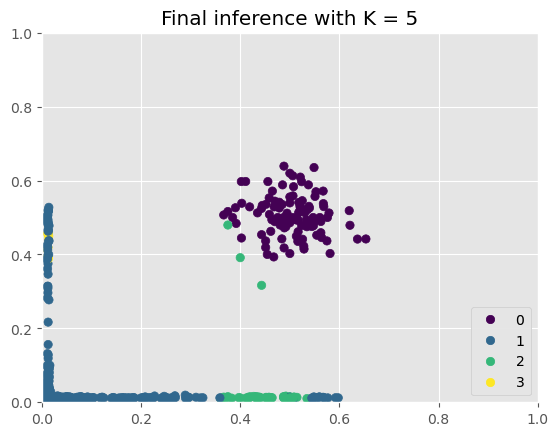

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(0)
NV = 0 after: tensor(0)
delta_param tensor([[[0.4040, 0.5960],
         [0.4007, 0.5993]],

        [[0.4042, 0.5958],
         [0.4044, 0.5956]],

        [[0.4040, 0.5960],
         [0.4040, 0.5960]],

        [[0.4042, 0.5958],
         [0.4040, 0.5960]],

        [[0.4040, 0.5960],
         [0.4042, 0.5958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 2509921.711361885
Iteration 200: Loss = 2445792.303666115
Iteration 400: Loss = 2653169.6367959976
Iteration 600: Loss = 2118708.6493082047
Iteration 800: Loss = 2008973.924027443
Iteration 1000: Loss = 2153880.7571573257
Iteration 1200: Loss = 2043860.4112100601
Iteration 1400: Loss = 2098968.948197365
Iteration 1600: Loss = 1909488.632279396
Iteration 1800: Loss = 2265978.1792764664
Iteration 2000: Loss = 2062123.5882120132
Iteration 2200: Loss = 1990865.4660196304
Iteration 2400: Loss = 2014543.9634561539
Iteration 2600: Loss = 2027429.3527383804
Iteration 2800: Loss = 2269533

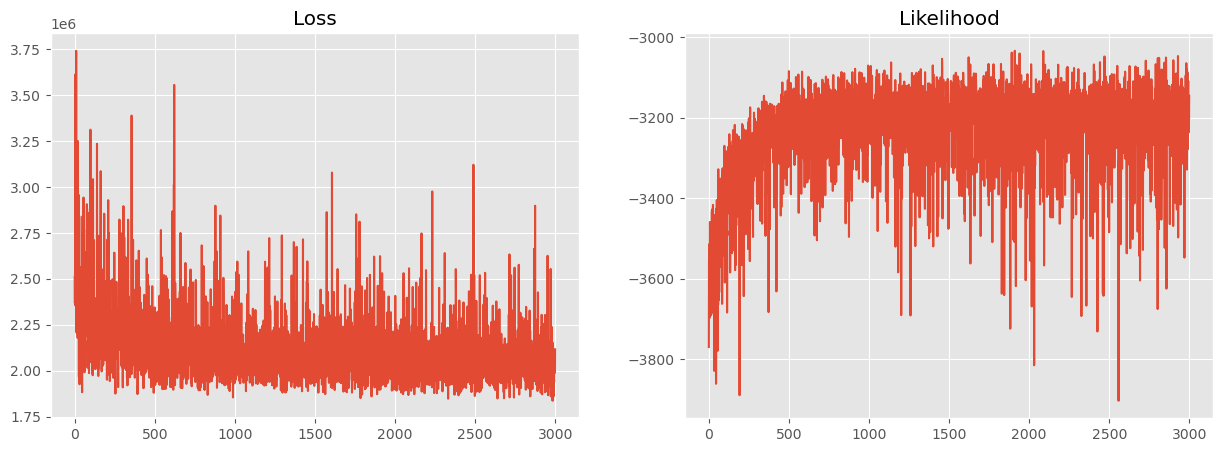

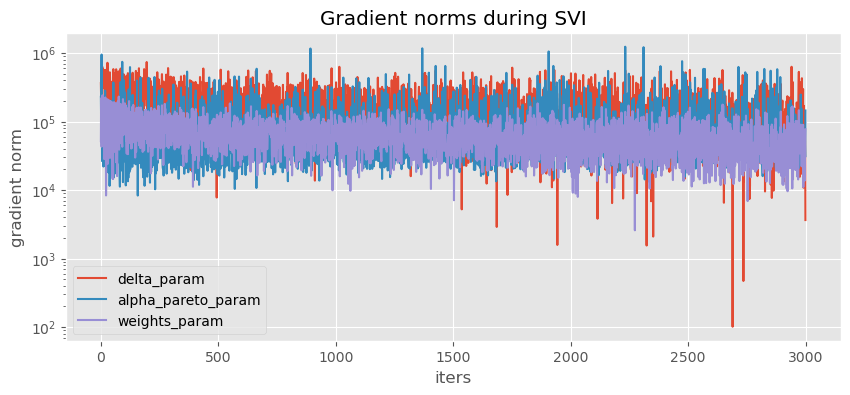

bic:  tensor(32567.5352, grad_fn=<RsubBackward1>)


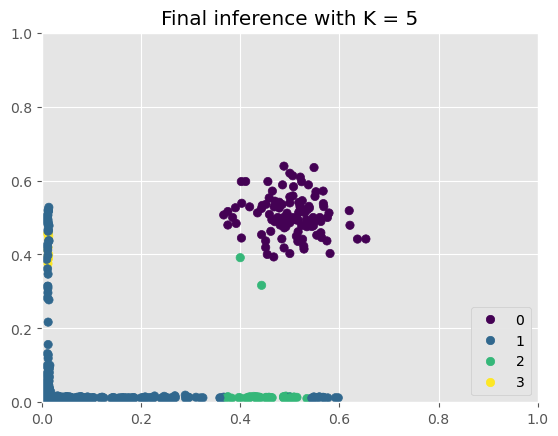

Selected number of clusters is 5 with seed 41


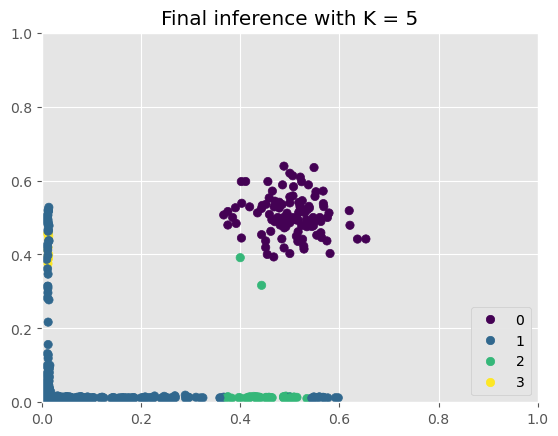

In [8]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [40,41], lr = 0.005)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


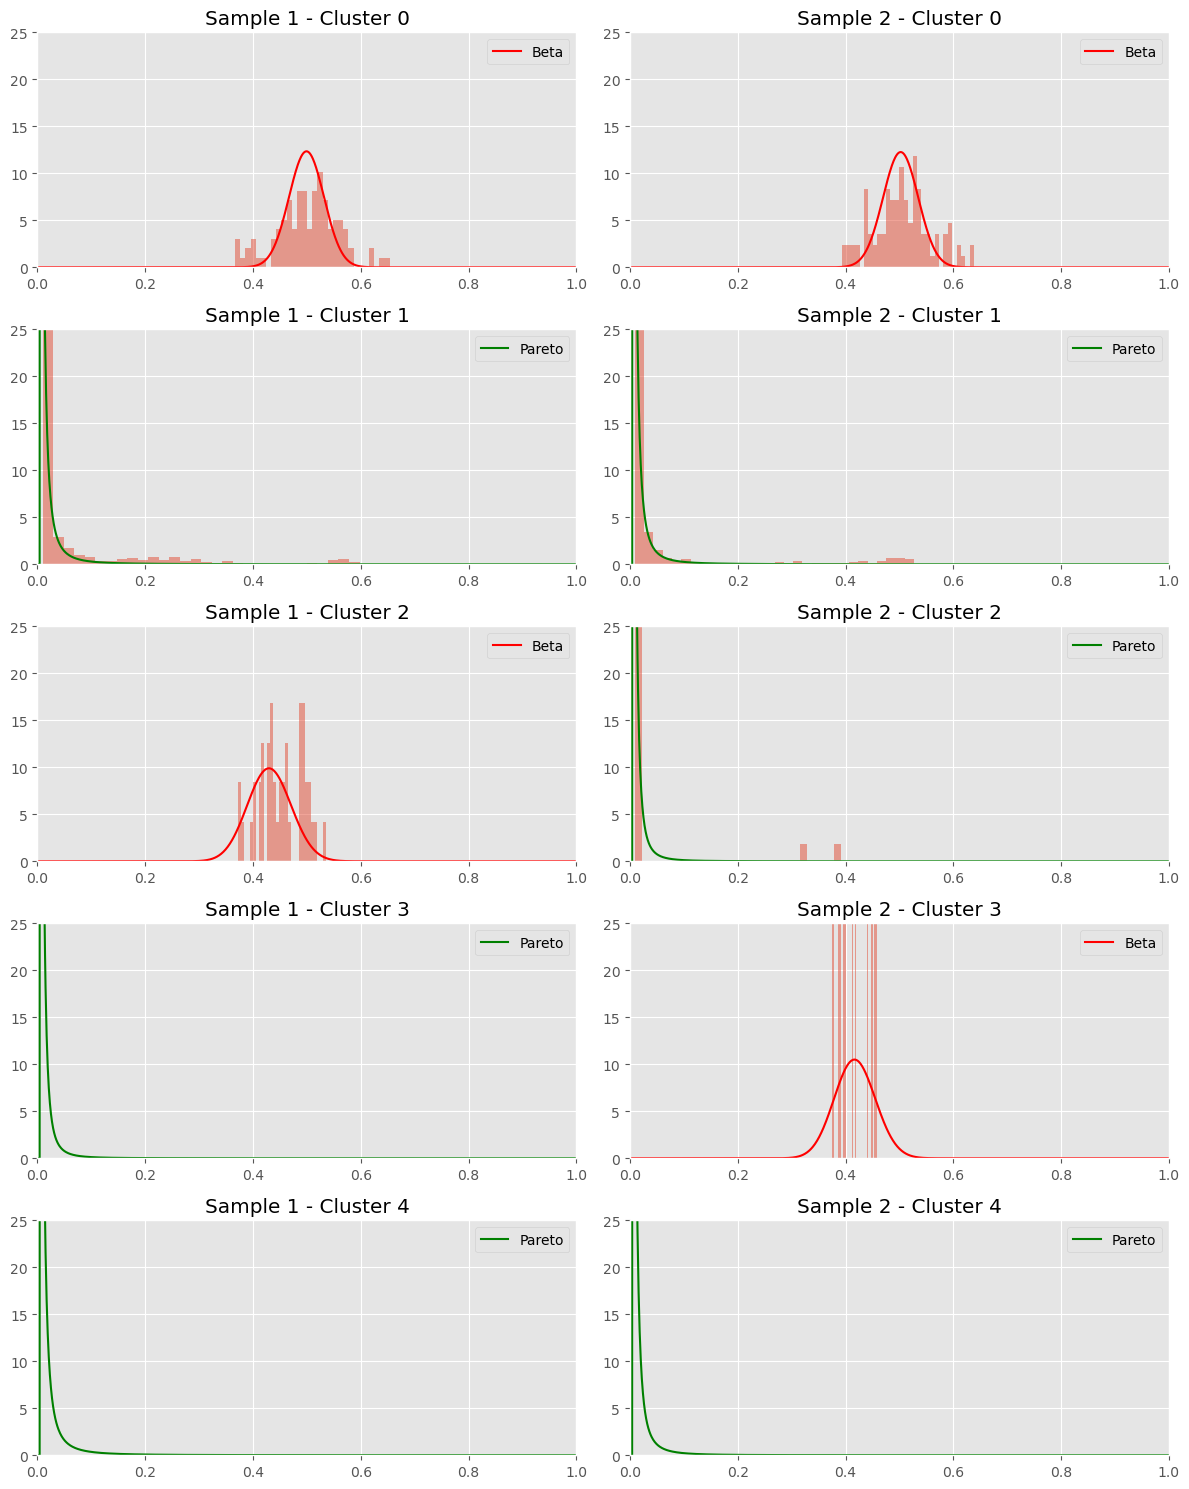

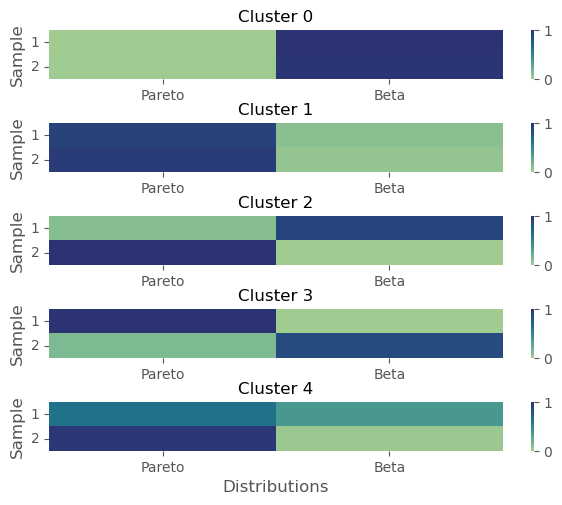

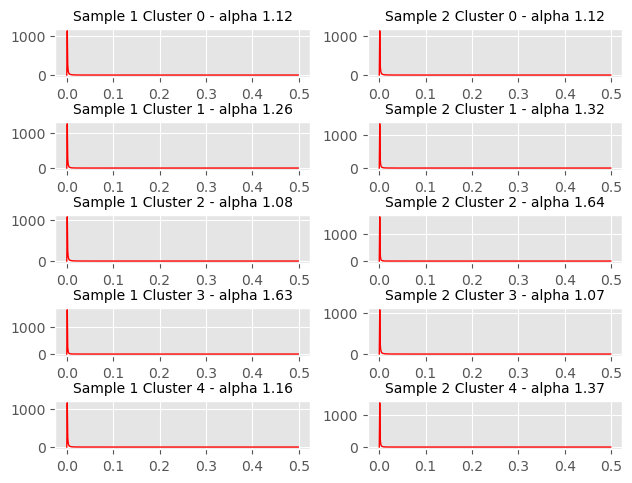

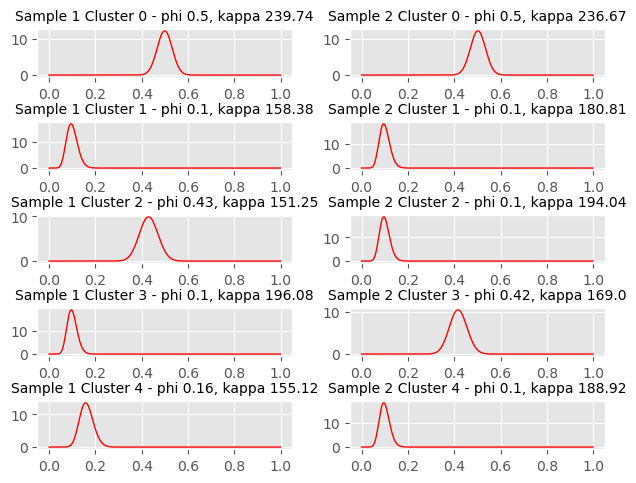

In [9]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [10]:
final_mb.params

{'weights_param': tensor([0.1823, 0.3311, 0.1419, 0.1004, 0.2443], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[1.1239, 1.1235],
         [1.2611, 1.3229],
         [1.0801, 1.6399],
         [1.6280, 1.0702],
         [1.1610, 1.3742]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.4992, 0.5022],
         [0.1000, 0.1000],
         [0.4304, 0.1000],
         [0.1000, 0.4175],
         [0.1622, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[239.7387, 236.6677],
         [158.3824, 180.8084],
         [151.2461, 194.0437],
         [196.0820, 169.0018],
         [155.1164, 188.9156]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.0152, 0.9848],
          [0.0201, 0.9799]],
 
         [[0.9044, 0.0956],
          [0.9387, 0.0613]],
 
         [[0.1109, 0.8891],
          [0.9861, 0.0139]],
 
         [[0.9816, 0.0184],
          [0.1422, 0.8578]],
 
         [[0.6282, 0.3718],
          [0.9645, 0.0355]]], grad_fn=<Di